## RNA-seq Data Analysis with SpliSER

Here I parse RNA-seq data from Mazin _et al._ to process it with SpliSER, and inspect the results.

## Data Processing

First, make an enviroment for processing the RNA data with SpliSER:

```bash
# conda env
conda create -n spliser python=3.10 -y
conda activate spliser
conda install -c bioconda pysam -y
conda install -c conda-forge ipykernel -y
python -m ipykernel install --user --name=spliser 
git clone -b speedups https://github.com/CraigIDent/SpliSER.git
cd SpliSER
pip install -e . --config-settings editable_mode=compat
```

To preprocess data, I use Splicevo environment.

I will run SpliSER for all samples from Mazin _et al_ - the bam files for all samples are listed in `samples_.txt`. First I will link the samples with metadata (from supplementary table 2 of Cardoso-Moreira et al.) and group replicates of the samples corresponding to the same time point and tissue/organ.

In [ ]:
import pandas as pd
from pathlib import Path

# Get current directory
wdir = Path().resolve()

# Project directory
project_dir = wdir.parent

# Load list of samples bam files
samples=pd.read_csv(Path(project_dir/ "data" / "spliser" / "bams.txt"),delimiter="\t")
# Create mock Timepoint column
samples["Timepoint"] = ""
# Create mock Group
samples["Group"] = samples["Species"] + '.' + samples["Organ_group"] + '.' + samples["Timepoint"]

# Load supplementary table with metadata
esm = pd.read_csv("ESM_Table_2.csv", delimiter=",")

# Merge by Library column
merged = pd.merge(samples, esm, on="Library", how="inner")

# Reorder columns
first_cols = ['Library', 'Species', 'Species_strain', 'Species_scientific_name', 'Organ_detail', 'Organ_group', 'Developmental_stage', 'Stage_detail', 'Timepoint', 'Group', 'Sex']
other_cols = [col for col in merged.columns if col not in first_cols]
cols = first_cols + other_cols
merged = merged[cols]


To map the samples with their developmental stages metadata to a aligned timepoints across developent, I will create a dictionary mapping each species' individual developmental stages to a common timepoint label (based on Extended Data Fig. 1 from Mazin et al.):

In [ ]:
timepoint_mapping = {
    'Human' : {
        '4wpc' : '1',
        '5wpc' : '2',
        '6wpc' : '3',
        '7wpc' : '4',
        '8wpc' : '5',
        '9wpc' : '6',
        '10wpc' : '6',
        '11wpc' : '6',
        '12wpc' : '7',
        '13wpc' : '8',
        '16wpc' : '9',
        '18wpc' : '10',
        '19wpc' : '10',
        '20wpc' : '11',
        'newborn' : '12',
        'infant' : '12',
        'toddler' : '12',
        'school': '13',
        'youngTeenager': '13',
        'teenager': '13',
        'oldTeenager' : '13',
        'youngAdult' : '13',
        'youngMidAge' : '14',
        'olderMidAge' : '14',
        'senior' : '15'
    },
    'Mouse' : {
        'e10.5' : '1',
        'e11.5' : '2',
        'e12.5' : '3',
        'e13.5' : '4',
        'e14.5' : '5',
        'e15.5' : '6',
        'e16.5' : '7',
        'e17.5' : '8',
        'e18.5' : '9',
        'P0' : '10',
        'P3' : '11',
        'P14' : '12',
        'P28' : '13',
        'P63' : '14'
    },
    'Macaque' : {
        'e93' : '10',
        'e109' : '10',
        'e112' : '11',
        'e113' : '11',
        'e123' : '11',
        'e130' : '11',
        'P0' : '12',
        '24 days post birth' : '12',
        'P6m' : '13',
        'P1y' : '14',
        'P3y' : '14',
        'P8y' : '14',
        'P9y' : '14',
        'P14-15y' : '15',
        'P20-26y' : '15',
        'P22-26y' : '15'
    },
    'Rat' : {
        'e11' : '1',
        'e12' : '2',
        'e13' : '3',
        'e14' : '3',
        'e15' : '4',
        'e16' : '5',
        'e17' : '6',
        'e18' : '7',
        'e19' : '8',
        'e20' : '9',
        'P0' : '10',
        'P3' : '11',
        'P7' : '12',
        'P14' : '12',
        'P42' : '13',
        'P112' : '14'
    }
}

Add timepoint info to metadata.

In [ ]:
# Add timepoint info to metadata
merged['Timepoint'] = merged.apply(lambda row: timepoint_mapping[row['Species']][row['Developmental_stage']] if row['Species'] in timepoint_mapping and row['Developmental_stage'] in timepoint_mapping[row['Species']] else row['Timepoint'], axis=1)
# Create Group column again
merged["Group"] = merged["Species"] + '.' + merged["Organ_group"] + '.' + merged["Timepoint"]
# Save
merged.to_csv("../data/spliser/samples.txt", sep="\t", index=False)

I will then run SpliSER on the helix cluster. I will create a job array for each species (modifying job submission script `scripts/spliser_job.sh` as needed to match species and nuber of groups i.e. jobs in an array). The paths to files to be processed and outputs to be saved are in the `scripts/spliser.sh`.

```bash
sbatch scripts/spliser_job.sh
```

SpliSER output files use `chr` notation, while the genome uses just numbers for chromosomes. I need to remove the `chr` prefix from the SpliSER usage files. I copy them from sds to `results/spliser` and process as shown below.

In [ ]:
usage_file="Mouse.Cerebellum.4wpb.combined.tsv"
awk -v OFS="\t" 'NR==1{print; next} {
    split($0, a, "\t");
    sub(/^chr/, "", a[2]);
    $0 = "";
    for (i=1; i<=length(a); i++) {
        printf "%s%s", a[i], (i==length(a) ? ORS : OFS);
    }
}' "$usage_file" > "${usage_file%.tsv}.nochr.tsv"
awk -F'\t' 'NR==1{n=NF; next} NF!=n{print "Line " NR ": " NF " fields"}' "${usage_file%.tsv}.nochr.tsv"

## SpliSER results

For this part, use SplicEvo enviroment because I need some of the IO functions from there.

### Overlap between splice sites with SpliSER usage info and annotated exon boundaries

Load an example SpliSER output file.

In [1]:
import pandas as pd
from pathlib import Path

# Get current directory
wdir = Path().resolve()

# Project directory
project_dir = wdir.parent
species = "Homo_sapiens"
name = "Human"
tissue = "Heart"
group = "0dpb"
filename = Path(project_dir, "results", "spliser", f"{name}.{tissue}.{group}.combined.nochr.tsv")

dtype = {
    'Sample': str,
    'Region': str,
    'Site': int,
    'Strand': str,
    'gene': str,
    'SSE': float,
    'alpha_count': int,
    'beta1_count': int,
    'beta2_count': int,
    'MultiGeneFlag': bool,
    'Others': str,
    'Partners': str,
    'Competitors': str
}
spliser_df = pd.read_csv(filename, sep="\t", dtype=dtype)

# Use better names
spliser_df.columns = spliser_df.columns.str.lower()
spliser_df = spliser_df.rename(columns={'region': 'chrom', 'strand': 'strand'})

# Get unique splice sites with tissue usage info
spliser_df = spliser_df.drop_duplicates(subset=['chrom', 'site'])

# Subset for test chromosomes
test_chr = ['1', '3', '5', '7', '9']
spliser_df = spliser_df[spliser_df['chrom'].isin(test_chr)]
spliser_df

,sample,chrom,site,strand,gene,sse,alpha_count,beta1_count,beta2_count,multigeneflag,others,partners,competitors
0,5843sTS.Human.Heart.0dpb.Female,1,14501,-,NaN,0.005,1,186,0,False,[],{14999: 1},[]
1,5843sTS.Human.Heart.0dpb.Female,1,14829,-,NaN,0.909,220,21,1,False,"[14501, 14999]","{14969: 218, 14929: 2}",[]
2,5843sTS.Human.Heart.0dpb.Female,1,14929,-,NaN,0.009,2,4,219,False,"[14501, 14999]",{14829: 2},[14969]
3,5843sTS.Human.Heart.0dpb.Female,1,14969,-,NaN,0.956,218,8,2,False,"[14501, 14999]",{14829: 218},[14929]
4,5843sTS.Human.Heart.0dpb.Female,1,14999,-,NaN,0.006,1,178,0,False,[],{14501: 1},[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
190823,5843sTS.Human.Heart.0dpb.Female,9,141130263,+,NaN,0.500,1,0,1,False,"[141121553, 141134069]",{141130359: 1},[]
190824,5843sTS.Human.Heart.0dpb.Female,9,141130359,+,NaN,0.500,1,0,1,False,"[141121553, 141134069]",{141130263: 1},[]
190825,5843sTS.Human.Heart.0dpb.Female,9,141134069,+,NaN,1.000,1,0,0,False,[],{141121553: 1},[]
190826,5843sTS.Human.Heart.0dpb.Female,9,141134179,+,NaN,1.000,1,0,0,False,[],{141135243: 1},[]


Load also gtf annotation file, and get exon boundaries from it, filtering only for exon boundaries that are also splice sites, i.e. excluding start of the first and end of the last exon per gene, respectively. 

In [2]:
from splicevo.io.gene_annotation import GTFProcessor

# Load gtf
gtf_path="/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz"
gtf = GTFProcessor(gtf_path)
gtf_df = gtf.load_gtf(chromosomes=test_chr)
exon_df = gtf_df[gtf_df['feature'] == 'exon']

# Get unique exons
exon_df = exon_df.sort_values(by=['chrom', 'start']).drop_duplicates(subset=['chrom', 'start', 'end'])

# Count number of exons per gene
exon_df['num_exons'] = exon_df.groupby('gene_id')['gene_id'].transform('count')

# Remove genes with single exon
exon_df = exon_df[(exon_df['num_exons'] > 1)]
splices_df = exon_df[['chrom', 'start', 'end', 'gene_id']].melt(id_vars=['chrom', 'gene_id'], value_vars=['start', 'end'], var_name='exon', value_name='site').drop_duplicates()

# Sort and add splice site rank per gene
splices_df = splices_df.sort_values(by=['chrom', 'site', 'gene_id']).reset_index(drop=True)
splices_df['rank'] = splices_df.groupby(['chrom', 'gene_id']).cumcount() + 1
splices_df['max_rank'] = splices_df.groupby(['chrom', 'gene_id'])['rank'].transform('max')

# Exclude first and last site per gene
splices_df = splices_df[(splices_df['rank'] > 1) & (splices_df['rank'] < splices_df['max_rank'])]
splices_df.reset_index(drop=True, inplace=True)
splices_df

/home/elek/miniforge3/envs/splicevo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading GTF file...
Loaded 1206773 GTF records


,chrom,gene_id,exon,site,rank,max_rank
0,1,hum.1,end,12227,2,4
1,1,hum.1,start,12613,3,4
2,1,hum.2,start,14336,2,144
3,1,hum.2,start,14339,3,144
4,1,hum.2,start,14344,4,144
...,...,...,...,...,...,...
282237,9,hum.67140,start,141143139,13,18
282238,9,hum.67140,end,141143667,14,18
282239,9,hum.67140,start,141149258,15,18
282240,9,hum.67140,end,141149410,16,18


How many SpliSER splice sites are annotated splice sites (i.e. exon boundaries, excluding start of the first and end of the last exon per gene)?

In [3]:
ovl_spl_ann = pd.merge(spliser_df, splices_df, on=['chrom', 'site'], how='inner')
print(f"{ovl_spl_ann.shape[0]} ({ovl_spl_ann.shape[0] / spliser_df.shape[0] * 100:.2f}%) splice sites are annotated exon boundaries.")

48482 (41.89%) splice sites are annotated exon boundaries.


In [10]:
# non-overlapping part
novl_spl_ann = pd.merge(spliser_df, splices_df, on=['chrom', 'site'], how='left', indicator=True)
novl_spl_ann = novl_spl_ann[novl_spl_ann['_merge'] == 'left_only'].drop(columns=['_merge'])
print(f"{novl_spl_ann.shape[0]} ({novl_spl_ann.shape[0] / spliser_df.shape[0] * 100:.2f}%) splice sites are not in the annotated gtf splice sites.")

novl_spl_ann.head()

67728 (58.52%) splice sites are not in the annotated gtf splice sites.


,sample,chrom,site,strand,gene,sse,alpha_count,beta1_count,beta2_count,multigeneflag,others,partners,competitors,gene_id,exon,rank,max_rank
0,5843sTS.Human.Heart.0dpb.Female,1,14501,-,NaN,0.005,1,186,0,False,[],{14999: 1},[],NaN,NaN,NaN,NaN
2,5843sTS.Human.Heart.0dpb.Female,1,14929,-,NaN,0.009,2,4,219,False,"[14501, 14999]",{14829: 2},[14969],NaN,NaN,NaN,NaN
3,5843sTS.Human.Heart.0dpb.Female,1,14969,-,NaN,0.956,218,8,2,False,"[14501, 14999]",{14829: 218},[14929],NaN,NaN,NaN,NaN
4,5843sTS.Human.Heart.0dpb.Female,1,14999,-,NaN,0.006,1,178,0,False,[],{14501: 1},[],NaN,NaN,NaN,NaN
6,5843sTS.Human.Heart.0dpb.Female,1,15310,-,NaN,0.070,5,13,53,False,[],{15038: 5},[15795],NaN,NaN,NaN,NaN


In [ ]:
from tqdm import tqdm

count_exonic = 0
count_intronic = 0
count_intergenic = 0
distances = {
    'exonic': [],
    'intronic': [],
    'intergenic': []
}

# what genomic regions are these non-overlapping sites located in?
exon_df = gtf_df[gtf_df['feature'] == 'exon']
transcript_df = gtf_df[gtf_df['feature'] == 'transcript']

#for index in tqdm(range(1000), desc="Processing splice sites", unit="site"):
for index in tqdm(range(novl_spl_ann.shape[0]), desc="Processing splice sites", unit="site"):
    row = novl_spl_ann.iloc[index]
    edf = exon_df[exon_df['chrom'] == row['chrom']]
    tdf = transcript_df[transcript_df['chrom'] == row['chrom']]

    # is row in transcript?
    transcript_ovl = tdf[ 
        (tdf['start'] <= row['site']) & 
        (tdf['end'] >= row['site'])]
    transcript_ovl = transcript_ovl.drop_duplicates(subset=['chrom', 'gene_id'])
    if transcript_ovl.shape[0] == 0:
        count_intergenic += 1
        # distance to nearest transcript start or end
        dist_to_starts = abs(tdf['start'] - row['site'])
        dist_to_ends = abs(tdf['end'] - row['site'])
        min_dist = min(dist_to_starts.min(), dist_to_ends.min())
        distances['intergenic'].append(min_dist)
    else:
        # is row in exon?
        exon_ovl = edf[
            (edf['start'] <= row['site']) &
            (edf['end'] >= row['site'])
        ]
        if exon_ovl.shape[0] == 0:
            count_intronic += 1
            # distance to nearest transcript start or end
            dist_to_starts = abs(transcript_ovl['start'] - row['site'])
            dist_to_ends = abs(transcript_ovl['end'] - row['site'])
            min_dist = min(dist_to_starts.min(), dist_to_ends.min())
            distances['intronic'].append(min_dist)
        else:
            count_exonic += 1
            # distance to nearest exon start or end
            dist_to_starts = abs(exon_ovl['start'] - row['site'])
            dist_to_ends = abs(exon_ovl['end'] - row['site'])
            min_dist = min(dist_to_starts.min(), dist_to_ends.min())
            distances['exonic'].append(min_dist)

print(f"Exonic: {count_exonic}, Intronic: {count_intronic}, Intergenic: {count_intergenic}")
print(f"Mean distances - Exonic: {sum(distances['exonic']) / len(distances['exonic']) if len(distances['exonic']) > 0 else 'N/A'}, Intronic: {sum(distances['intronic']) / len(distances['intronic']) if len(distances['intronic']) > 0 else 'N/A'}, Intergenic: {sum(distances['intergenic']) / len(distances['intergenic']) if len(distances['intergenic']) > 0 else 'N/A'}")


Processing splice sites: 100%|██████████| 1000/1000 [01:47<00:00,  9.33site/s]

Exonic: 595, Intronic: 403, Intergenic: 2
Mean distances - Exonic: 165.79327731092437, Intronic: 19676.82382133995, Intergenic: 6.0


In [28]:
novl_spl_ann.shape[0]

67728

In [4]:
# Control: shift SpliSER usage site
shifts = [-3, -2, -1, 0, 1, 2, 3]
for shift in shifts:
    spliser_df_shifted = spliser_df.copy()
    spliser_df_shifted['site'] = spliser_df_shifted['site'] + shift
    ovl_spl_ann_shifted = pd.merge(spliser_df_shifted, splices_df, on=['chrom', 'site'], how='inner')
    print(f"Shift {shift}: {ovl_spl_ann_shifted.shape[0]} ({ovl_spl_ann_shifted.shape[0] / spliser_df.shape[0] * 100:.2f}%)")

Shift -3: 732 (0.63%)
Shift -2: 652 (0.56%)
Shift -1: 498 (0.43%)
Shift 0: 48482 (41.89%)
Shift 1: 48357 (41.78%)
Shift 2: 422 (0.36%)
Shift 3: 670 (0.58%)


How many exon boundaries (excluding start and end of first and last exon per gene) are splice sites with SpliSER usage info?

In [5]:
# Merge with splice sites
ovl_ann_spl = pd.merge(splices_df, spliser_df, on=['chrom', 'site'], how='inner')
print(f"{ovl_ann_spl.shape[0]} ({ovl_ann_spl.shape[0] / splices_df.shape[0] * 100:.2f}%) annotated exon boundaries (excluding start of the first and end of the last exon per gene, respectively) have usage info .")

48482 (17.18%) annotated exon boundaries (excluding start of the first and end of the last exon per gene, respectively) have usage info .


In [5]:
# Control: shift exon boundary splice site
shifts = [-3, -2, -1, 0, 1, 2, 3]
for shift in shifts:
    splices_df_shifted = splices_df.copy()
    splices_df_shifted['site'] = splices_df_shifted['site'] + shift
    ovl_ann_spl_shifted = pd.merge(splices_df_shifted, spliser_df, on=['chrom', 'site'], how='inner')
    print(f"{shift}: {ovl_ann_spl_shifted.shape[0]} ({ovl_ann_spl_shifted.shape[0] / splices_df.shape[0] * 100:.2f}%)")

-3: 670 (0.24%)
-2: 422 (0.15%)
-1: 48357 (17.13%)
0: 48482 (17.18%)
1: 498 (0.18%)
2: 652 (0.23%)
3: 732 (0.26%)


Combine the analysis above into a function.

In [7]:
# A function that takes SpliSER df and GTF path as input and returns the overlap stats, optionally performing controls with shifted splice sites
from typing_extensions import Optional, List


def splice_site_annotation_overlap(
    spliser_path: Optional[str] = None,
    gtf_path: Optional[str] = None,
    gtf_df: Optional[pd.DataFrame] = None,
    spliser_df: Optional[pd.DataFrame] = None,
    test_chr: Optional[List[str]] = None,
    shift_controls: Optional[List[int]] = None,
    verbose: bool = True,
):
    import pandas as pd
    from splicevo.io.gene_annotation import GTFProcessor

    # Load gtf
    if gtf_df is None:
        gtf = GTFProcessor(gtf_path)
        gtf_df = gtf.load_gtf(chromosomes=test_chr)
    else:
        gtf_df = gtf_df[gtf_df['chrom'].isin(test_chr)] if test_chr is not None else gtf_df
    
    # Get exons
    exon_df = gtf_df[gtf_df['feature'] == 'exon']

    # Get unique exons
    exon_df = exon_df.sort_values(by=['chrom', 'start']).drop_duplicates(subset=['chrom', 'start', 'end'])

    # Count number of exons per gene
    exon_df['num_exons'] = exon_df.groupby('gene_id')['gene_id'].transform('count')

    # Remove genes with single exon
    exon_df = exon_df[(exon_df['num_exons'] > 1)]
    splices_df = exon_df[['chrom', 'start', 'end', 'gene_id']].melt(id_vars=['chrom', 'gene_id'], value_vars=['start', 'end'], var_name='exon', value_name='site').drop_duplicates()
    
    # Sort and add splice site rank per gene
    splices_df = splices_df.sort_values(by=['chrom', 'site', 'gene_id']).reset_index(drop=True)
    splices_df['rank'] = splices_df.groupby(['chrom', 'gene_id']).cumcount() + 1
    splices_df['max_rank'] = splices_df.groupby(['chrom', 'gene_id'])['rank'].transform('max')

    # Exclude first and last site per gene
    splices_df = splices_df[(splices_df['rank'] > 1) & (splices_df['rank'] < splices_df['max_rank'])]
    splices_df.reset_index(drop=True, inplace=True)
    
    # Load SpliSER df
    dtype = {
        'Sample': str,
        'Region': str,
        'Site': int,
        'Strand': str,
        'gene': str,
        'SSE': float,
        'alpha_count': int,
        'beta1_count': int,
        'beta2_count': int,
        'MultiGeneFlag': bool,
        'Others': str,
        'Partners': str,
        'Competitors': str
    }
    spliser_df = pd.read_csv(spliser_path, sep="\t", dtype=dtype)
    # Use better names
    spliser_df.columns = spliser_df.columns.str.lower()
    spliser_df = spliser_df.rename(columns={'region': 'chrom', 'strand': 'strand'})
    # Get unique splice sites with tissue usage info
    spliser_df = spliser_df.drop_duplicates(subset=['chrom', 'site'])
    # Subset for test chromosomes
    if test_chr is not None:
        spliser_df = spliser_df[spliser_df['chrom'].isin(test_chr)] 

    # Overlap calculations
    ovl_spl_ann = pd.merge(spliser_df, splices_df, on=['chrom', 'site'], how='inner')
    ovl_spl_ann_ovl = {
        'vals': ovl_spl_ann.shape[0],
        'frac': ovl_spl_ann.shape[0] / spliser_df.shape[0]
    }

    if verbose:
        print(f"{ovl_spl_ann_ovl['vals']} ({ovl_spl_ann_ovl['frac'] * 100:.2f}%) splice sites with usage info are annotated exon boundaries (excluding start of the first and end of the last exon per gene, respectively).")
    
    if shift_controls is not None:
        ovl_spl_ann_shifts = {
            'vals': {},
            'frac': {}
        }
        for shift in shift_controls:
            spliser_df_shifted = spliser_df.copy()
            spliser_df_shifted['site'] = spliser_df_shifted['site'] + shift
            ovl_spl_ann_shifted = pd.merge(spliser_df_shifted, splices_df, on=['chrom', 'site'], how='inner')
            ovl_spl_ann_shift = ovl_spl_ann_shifted.shape[0]
            ovl_spl_ann_shifts['vals'][shift] = ovl_spl_ann_shift
            ovl_spl_ann_shifts['frac'][shift] = ovl_spl_ann_shift / spliser_df.shape[0]
            if verbose:
                print(f"Shift {shift}: {ovl_spl_ann_shift} ({ovl_spl_ann_shift / spliser_df.shape[0] * 100:.2f}%)")


    ovl_ann_spl = pd.merge(splices_df, spliser_df, on=['chrom', 'site'], how='inner')
    ovl_ann_spl_ovl = {
        'vals': ovl_ann_spl.shape[0],
        'frac': ovl_ann_spl.shape[0] / splices_df.shape[0]
    }
    
    if verbose:
        print(f"{ovl_ann_spl_ovl['vals']} ({ovl_ann_spl_ovl['frac'] * 100:.2f}%) annotated exon boundaries (excluding start of the first and end of the last exon per gene, respectively) have usage info .")

    if shift_controls is not None:
        ovl_ann_spl_shifts = {
            'vals': {},
            'frac': {}
        }
        for shift in shift_controls:
            splices_df_shifted = splices_df.copy()
            splices_df_shifted['site'] = splices_df_shifted['site'] + shift
            ovl_ann_spl_shifted = pd.merge(splices_df_shifted, spliser_df, on=['chrom', 'site'], how='inner')
            ovl_ann_spl_shift = ovl_ann_spl_shifted.shape[0]
            ovl_ann_spl_shifts['vals'][shift] = ovl_ann_spl_shift
            ovl_ann_spl_shifts['frac'][shift] = ovl_ann_spl_shift / splices_df.shape[0]
            if verbose:
                print(f"Shift {shift}: {ovl_ann_spl_shift} ({ovl_ann_spl_shift / splices_df.shape[0] * 100:.2f}%)")

            
    if shift_controls is None:
        ovl_spl_ann_shifts, ovl_ann_spl_shifts = None, None

    return ovl_spl_ann_ovl, ovl_ann_spl_ovl, ovl_spl_ann_shifts, ovl_ann_spl_shifts


In [8]:
# A function to plot shift control results
def plot_shift_control_results(shift_results, title = "Overlap of splice sites", logy1=False, logy2=False, plot_file=None, plot_file_dpi=300):
    """
    Plot shift control results.
    Parameters:
    shift_results (Dict): Dictionary with shift values and overlap counts.
    title (str): Title of the plot.
    xlabel (str): Label for the x-axis.
    """
    import matplotlib.pyplot as plt

    shifts = list(shift_results['vals'].keys())
    counts = list(shift_results['vals'].values())
    fracts = list(shift_results['frac'].values())
    percts = [x * 100 for x in fracts]

    # barplot with two y-axes: percentages and counts
    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax1.bar(shifts, counts, color='skyblue')
    ax1.set_xlabel('Shift Value')
    ax1.set_ylabel('Number of Overlapping Splice Sites')
    ax1.set_title(title)
    ax1.set_xticks(shifts)
    if len(shifts) > 10 and len(shifts) <= 50:
        plt.xticks(rotation=90)
    elif len(shifts) > 50:
        plt.xticks(shifts[::5], rotation=90)
    ax1.grid(axis='y')
    if logy1:
        ax1.set_yscale('log')

    ax2 = ax1.twinx()
    ax2.plot(shifts, percts, color='orange', marker='o', markersize=0)
    ax2.set_ylabel('Percentage of Overlapping Splice Sites')
    if logy2:
        ax2.set_yscale('log')

    ax1.legend(['Counts'], loc='upper left')
    ax2.legend(['Percentage'], loc='upper right')
    if plot_file is not None:
        plt.savefig(plot_file, bbox_inches='tight', dpi=plot_file_dpi)
    plt.show()

On the example of one tissue splice site usage, estimate the overlap of tissue splice sites with annotated exon boundaries, and vice versa, across a wide genomic interval of ~100 bp (median length of most introns).

In [9]:
import pandas as pd
from pathlib import Path

# Get current directory
wdir = Path().resolve()

# Build file paths
project_dir = wdir.parent
species = "Homo_sapiens"
name = "Human"
tissue = "Heart"
group = "0dpb"
spliser_path = Path(project_dir, "results", "spliser", f"{name}.{tissue}.{group}.combined.nochr.tsv")

# GTF file path
gtf_path="/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz"

# Calculate overlaps of sites
ovl_spl_ann_ovl, ovl_ann_spl_ovl, ovl_spl_ann_shifts, ovl_ann_spl_shifts = splice_site_annotation_overlap(spliser_path, gtf_path, shift_controls=list(range(-100, 101)), verbose=False)

Loading GTF file...
Loaded 4049432 GTF records


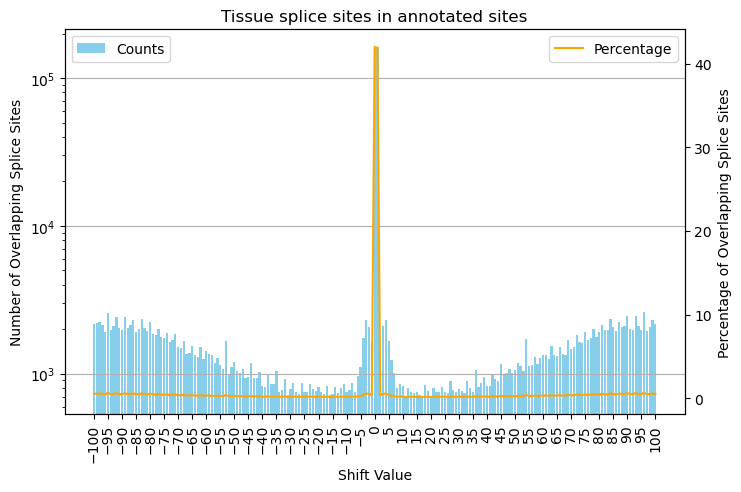

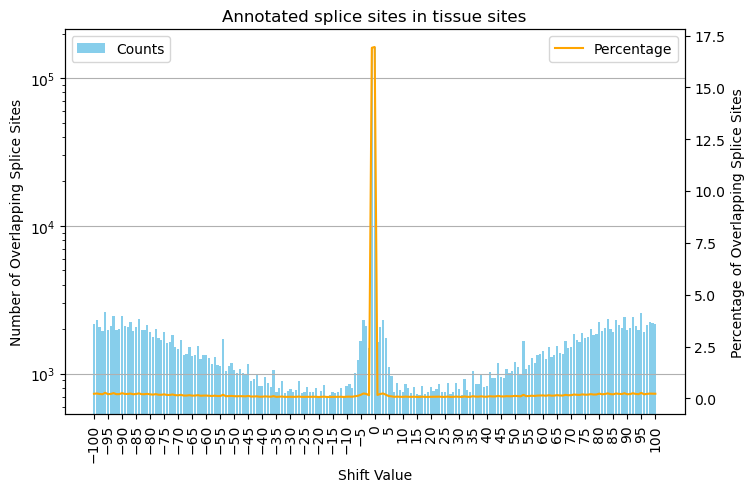

In [10]:
# Plot shift controls
plot_shift_control_results(ovl_spl_ann_shifts, title = "Tissue splice sites in annotated sites", logy1=True, logy2=False, plot_file="plots/splice_site_ovl_of_spliser_in_annot_100_bp.pdf")
plot_shift_control_results(ovl_ann_spl_shifts, title = "Annotated splice sites in tissue sites", logy1=True, logy2=False, plot_file="plots/splice_site_ovl_of_annot_in_spliser_100_bp.pdf")

Loading GTF file...
Loaded 4045835 GTF records


In [23]:
# SpliSER paths
species_names = {
    "Human": "Homo_sapiens",
    "Mouse": "Mus_musculus"
}
species_gtfs = {
    "Human": "/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz",
    "Mouse": "/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Mus_musculus.gtf.gz"
}
species_chrs = {
    "Human": [str(i) for i in range(1, 22)] + ['X', 'Y', 'MT'],
    "Mouse": [str(i) for i in range(1, 19)] + ['X', 'Y', 'MT']
}
ovls = {}

for name in ["Human", "Mouse"]:

    species = species_names[name]
    gtf_path=species_gtfs[name]
    all_chroms = species_chrs[name]

    gtf = GTFProcessor(gtf_path)
    gtf_df = gtf.load_gtf(chromosomes=all_chroms)

    for tissue in ["Heart", "Cerebellum", "Kidney"]:
        for group in ["0dpb", "4wpb", "29ypb"]:

            id = f"{name}.{tissue}.{group}"
            spliser_path = Path(project_dir, "results", "spliser", f"{id}.combined.nochr.tsv")
            
            if spliser_path.exists():

                print(f"Loading SpliSER data for {id}")

                # Load the data
                spliser_data = pd.read_csv(spliser_path, sep="\t", dtype=str)

                # Calculate overlaps of sites
                ovl_spl_ann_ovl, ovl_ann_spl_ovl, _, _ = splice_site_annotation_overlap(spliser_path=spliser_path, gtf_df=gtf_df, verbose=True)

                # Store the results
                ovls[id] = {
                    "ovl_spl_ann_ovl": ovl_spl_ann_ovl,
                    "ovl_ann_spl_ovl": ovl_ann_spl_ovl
                }

Loading GTF file...
Loaded 3936680 GTF records
Loading SpliSER data for Human.Heart.0dpb
158468 (41.02%) splice sites with usage info are annotated exon boundaries (excluding start of the first and end of the last exon per gene, respectively).
158468 (17.02%) annotated exon boundaries (excluding start of the first and end of the last exon per gene, respectively) have usage info .
Loading SpliSER data for Human.Cerebellum.0dpb
178949 (40.53%) splice sites with usage info are annotated exon boundaries (excluding start of the first and end of the last exon per gene, respectively).
178949 (19.22%) annotated exon boundaries (excluding start of the first and end of the last exon per gene, respectively) have usage info .
Loading SpliSER data for Human.Cerebellum.29ypb
196886 (29.33%) splice sites with usage info are annotated exon boundaries (excluding start of the first and end of the last exon per gene, respectively).
196886 (21.15%) annotated exon boundaries (excluding start of the first a

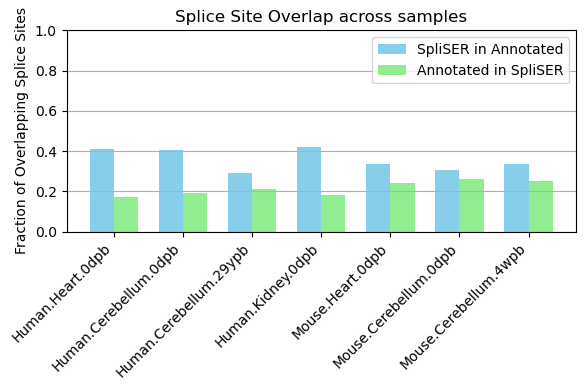

In [24]:
import numpy as np
import matplotlib.pyplot as plt

labels = list(ovls.keys())
fracs_spl_in_ann = [ovls[k]['ovl_spl_ann_ovl']['frac'] for k in labels]
fracs_ann_in_spl = [ovls[k]['ovl_ann_spl_ovl']['frac'] for k in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(max(6, len(labels) * 0.6), 4))
ax.bar(x - width/2, fracs_spl_in_ann, width, label='SpliSER in Annotated', color='skyblue')
ax.bar(x + width/2, fracs_ann_in_spl, width, label='Annotated in SpliSER', color='lightgreen')

ax.set_ylim(0, 1)
ax.set_ylabel('Fraction of Overlapping Splice Sites')
ax.set_title('Splice Site Overlap across samples')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y')

plt.tight_layout()
plt.savefig("plots/splice_site_overlap_all_ids.pdf", bbox_inches='tight', dpi=300)
plt.show()
